<b><span style="color:red">NSFW WARNING: NOTE THAT THERE ARE UNCENSORED SWEAR WORDS IN THIS ASSIGNMENT</span></b>.

# Analyzing Bad Mouths

## Part 1: Project Milestone: Setting Up Data Pipeline

I will first setup the data pipeline and then write some initial analyses.

First, read the text_submissions file.

In [93]:
import pandas as pd
full_text_submissions = pd.read_csv('text_submissions.csv.gz', low_memory=False)

Get posts from subreddits with around 100 posts.

In [120]:
subreddit_post_count = full_text_submissions.groupby("subreddit").count()
subreddit_post_count = subreddit_post_count.sort_values(by=['id'], ascending=False)

# select subreddits with around 100 posts
selected_subreddits_df = subreddit_post_count.loc[abs(subreddit_post_count['id'] - 100) < 6]
selected_subreddits = list(selected_subreddits_df.index)

# select posts in posted in selected_subreddits
text_submissions = full_text_submissions.loc[full_text_submissions['subreddit'].isin(selected_subreddits)]
original_text_submissions_sample = text_submissions
text_submissions

,id,author,created_utc,domain,is_self,score,selftext,title,subreddit
36871,t3_nphxee,[deleted],1622509019,self.falloutlore,True,1.0,[deleted],What explains the change of the aliens’ appear...,falloutlore
36872,t3_nvsebr,ProfVerstrooid,1623233987,self.falloutlore,True,1.0,[removed],A possible wrench in the 'Divergence Theory': ...,falloutlore
36873,t3_nwa1fs,Casual_War_Crimes,1623283354,self.falloutlore,True,1.0,[removed],I have a question,falloutlore
36874,t3_fzsf0i,donotusethisaccountu,1586676899,self.falloutlore,True,30.0,He wanted to control an army and a deadly gas ...,What was Elijah’s ultimate goal?,falloutlore
36875,t3_o1n293,Samueldedieu1,1623899700,self.falloutlore,True,14.0,[removed],how many deathclaw would it take to take down ...,falloutlore
...,...,...,...,...,...,...,...,...,...
3493152,t3_bhk0of,toufiinjapan,1556267840,self.japancirclejerk,True,23.0,[https://www.reddit.com/r/relationships/commen...,Weeb wants to ask Huang to act like Hanako,japancirclejerk
3494110,t3_dn7mqx,LawnDartEnthusiast,1572055871,espn.com,False,189.0,NaN,Linus just put up a 41 save shutout. LFG.,sabres
3494316,t3_cftigi,annekh510,1563672195,self.illnessfakers,True,6.0,[removed],Why we do this?,illnessfakers
3494660,t3_b0dcyg,minutial,1552426128,self.awardtravel,True,3.0,I believe Hotel Hustle is no longer working. I...,Hotel award availability search tool?,awardtravel


Remove submissions without selftext.

In [121]:
text_submissions = text_submissions.loc[~text_submissions['selftext'].isnull()]
text_submissions = text_submissions.loc[text_submissions['selftext'] != '[deleted]']
text_submissions = text_submissions.loc[text_submissions['selftext'] != '[removed]']

Tokenize selftext and call pandas "explode" method on selftext.

In [122]:
import nltk 
text_submissions["selftext"] = text_submissions["selftext"].apply(lambda x: nltk.word_tokenize(x.lower()))
text_submissions = text_submissions.explode("selftext")
text_submissions = text_submissions[["id", "selftext"]]
text_submissions["count"] = 1

Remove sequences of characters from words that aren't part of the word (e.g., "\n", url's, and punctuation). 

In [123]:
import re

def remove_non_alphanum(string):
    result = []
    for char in string:
        if char.isalnum():
            result.append(char)
    return "".join(result)

text_submissions["selftext"] = text_submissions["selftext"].apply(lambda x: re.sub(r'http\S+', '', str(x)))
to_remove = {"\n", "&#x200b;"}
for string in to_remove:
        text_submissions["selftext"] = text_submissions["selftext"].apply(lambda x: x.replace(string, ""))

text_submissions["selftext"] = text_submissions["selftext"].apply(remove_non_alphanum)
text_submissions = text_submissions.loc[text_submissions['selftext'] != '']

Group and sum rows to find the frequency of words in each submission.

In [124]:
text_submissions = text_submissions.groupby(["id", "selftext"]).sum()

Pivot text_submissions to get desired format.

In [125]:
text_submissions = text_submissions.reset_index()
text_submissions = text_submissions.pivot(index="id", columns="selftext", values="count").fillna(0)        

Create dataframe that counts the frequency of swear words in each submission.

In [126]:
swear_words = []

for word in list(text_submissions.columns):
    if "fuck" in word or "shit" in word:
        swear_words.append(word)
        
swear_count = text_submissions[swear_words]

swear_count = swear_count.assign(swear_count=swear_count.sum(axis=1))
swear_count = swear_count.assign(total_word_count=text_submissions.sum(axis=1))
swear_percentages = 100 * swear_count['swear_count'] / swear_count['total_word_count']
swear_count = swear_count.assign(swear_percentage=swear_percentages)

Find the percentage of submissions that contain a swear word.

In [127]:
swear_percentages_list = list(swear_count["swear_percentage"])
no_swear_percent = 100 * swear_percentages_list.count(0) / len(swear_percentages_list)
global_swear_percent = 100 - no_swear_percent
print("{global_swear_percent}% of submissions contain a swear word.".format(global_swear_percent=global_swear_percent))

7.050359712230218% of submissions contain a swear word.


Out of submissions that contain a swear word, plot the percentage of words that are swear words.

Text(0,0.5,'Number of submissions')

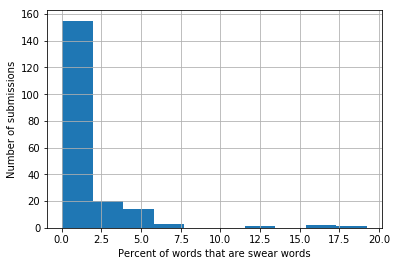

In [128]:
plot = swear_count.loc[swear_count['swear_percentage'] != 0]["swear_percentage"].hist()
plot.set_xlabel("Percent of words that are swear words")
plot.set_ylabel("Number of submissions")

Initial analyses:

I noticed that only a small portion of submissions contain a swear word. This means that I will have to make sure to use enough submissions so that I will have enough submissions with a swear word. 

I also plotted the percent of words in submissions that are swear words and noticed that most submissions with swear words have a very small percent of swear words (under 2.5%). 

## Part 2: Analyzing Proportion of Posts that Swear in Different Sub-Reddits

In [129]:
# show whether each post swears or not
swore = swear_count["swear_count"] > 0

swore = swore.to_frame()
swore = swore.rename(columns={"swear_count": "swore?"})

In [130]:
# add subreddit column to swore
original_text_submissions_sample = original_text_submissions_sample.set_index("id")
swore["subreddit"] = original_text_submissions_sample["subreddit"]

# group by subreddit and find proportion of posts that swear. Remove subreddits with only one post
subreddits = swore.groupby('subreddit').agg(['sum','count'])
subreddits.columns = subreddits.columns.droplevel(0)
subreddits = subreddits.loc[subreddits['count'] > 1]
subreddits["swear_proportion"] = subreddits["sum"] / subreddits["count"]
subreddits = subreddits.sort_values(by='swear_proportion')

Text(0.0715036,3,'Average')

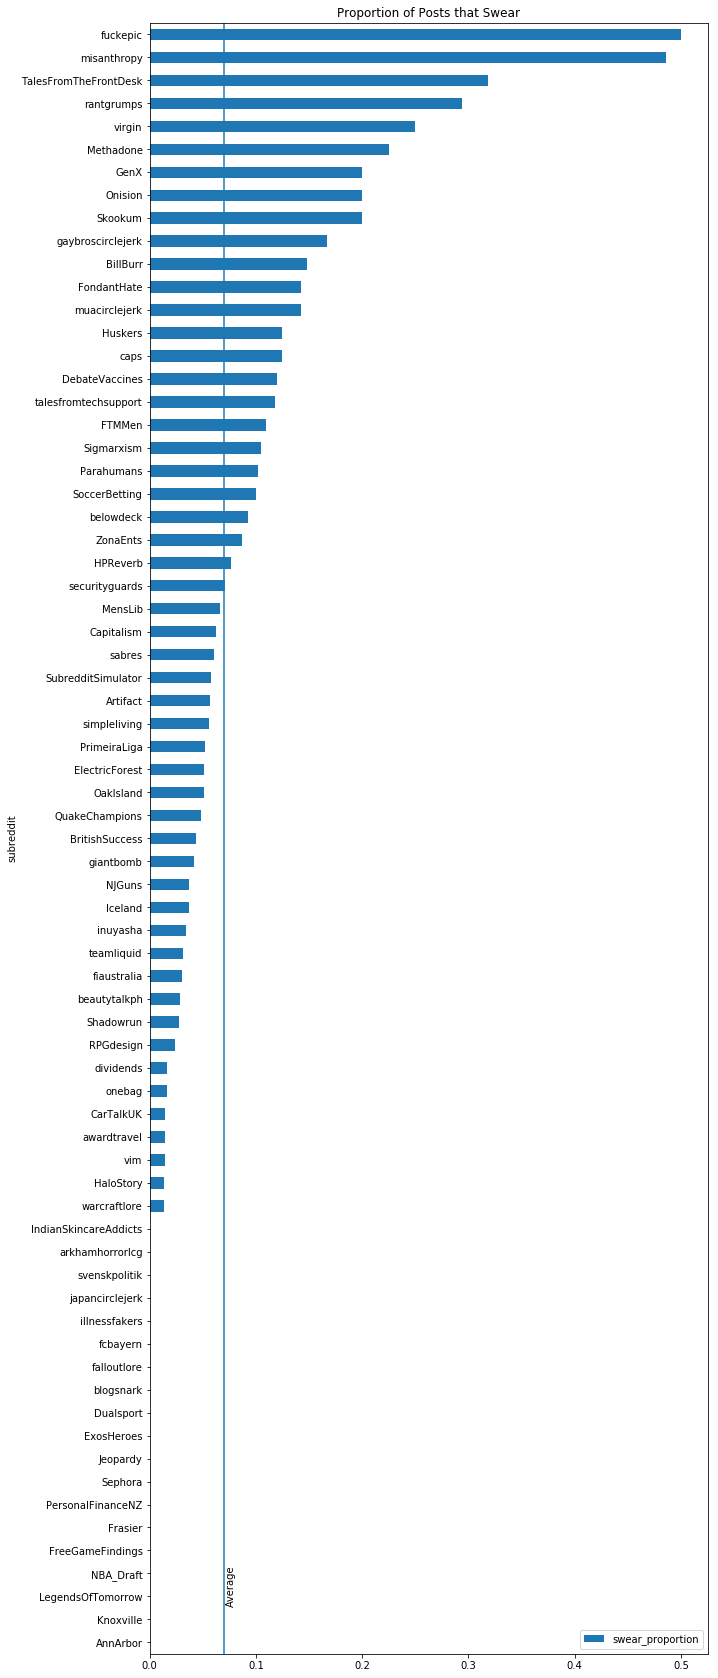

In [131]:
ax = subreddits.plot.barh(figsize=(10,30), y="swear_proportion", title="Proportion of Posts that Swear")
average_swear_proportion = global_swear_percent / 100
ax.axvline(x=average_swear_proportion)
ax.text(average_swear_proportion + 0.001,3,'Average',rotation=90)

In [132]:
swore.groupby('subreddit').agg(['mean'])
swore["score"] = original_text_submissions_sample["score"]
post_scores = swore.groupby(['subreddit', 'swore?']).agg(['median', 'count'])

# drop column level
post_scores.columns = post_scores.columns.droplevel()
post_scores = post_scores.rename(columns={"median": "median score"})

# remove rows with only one post 
post_scores = post_scores.loc[post_scores['count'] > 0]

post_scores = post_scores.unstack()

# drop subreddits that don't have both posts that swear and posts that don't swear
post_scores = post_scores.dropna()

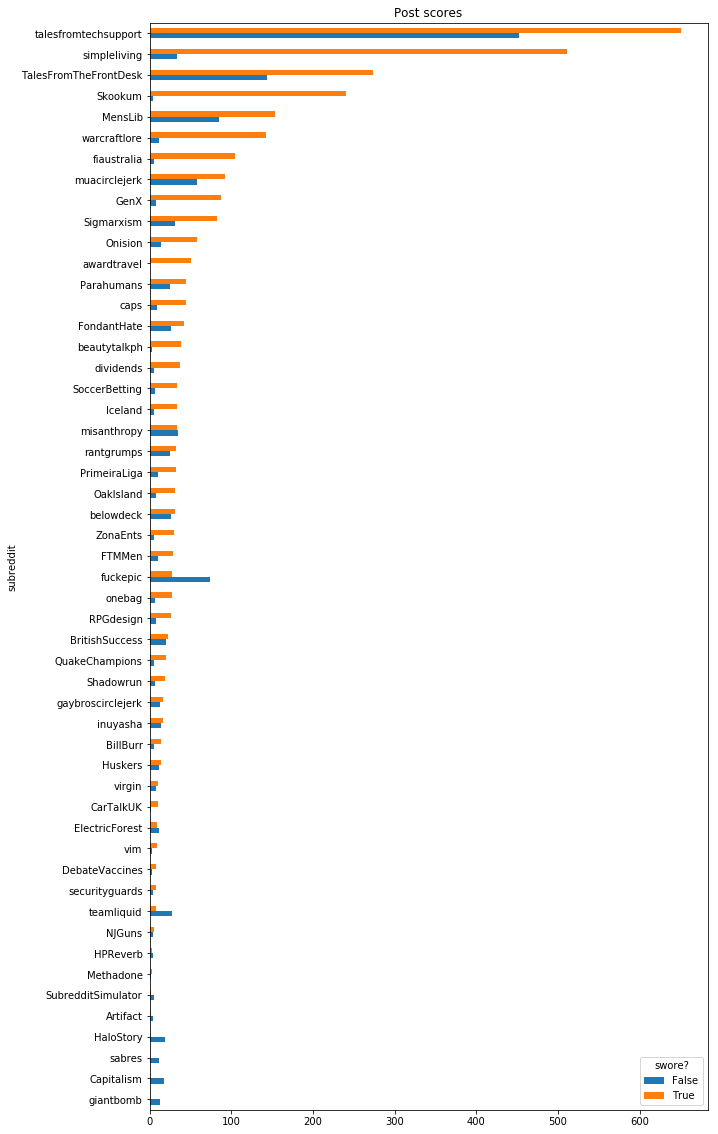

In [133]:
post_scores = post_scores.sort_values([('median score', True)], ascending=True)

# plot results
ax = post_scores.plot.barh(figsize=(10,20), y="median score", title="Post scores")

In [134]:
import numpy as np

# create column for ratio of score in posts that swear vs. posts that don't swear
post_scores["score ratio"] = post_scores[('median score', True)] / post_scores[('median score', False)]
post_scores = post_scores.sort_values('score ratio', ascending=False)


In [135]:
print("Out of the sampled subreddits, the average ratio of scores of posts that swear to scores of posts \
that don\'t swear is: ", np.mean(list(post_scores["score ratio"])))
print("\nOut of the sampled subreddits, the median ratio of scores of posts that swear to scores of posts \
that don\'t swear is: ", np.median(list(post_scores["score ratio"])))

Out of the sampled subreddits, the average ratio of scores of posts that swear to scores of posts that don't swear is:  5.408527796272671

Out of the sampled subreddits, the median ratio of scores of posts that swear to scores of posts that don't swear is:  1.9496527777777777


In [136]:
# After trying two different methods, I was not able to find a pattern showing which communities swearing is most/least favored in (based on the score of posts that have a swear word). The first method I tried was manually inspecting the subreddits with a large or small "score ratio" (the score ratio is ratio of scores of posts that swear to scores of posts \
# that don't swear). Next, I wanted to see if there's a correlation between 
# "swear proportion" (the proportion of posts in a subreddit that swear) and "score ratio", I reran the whole notebook multiple times and used the pandas corr function
# to find the Pearson coefficient. There was always a moderate or weak correlation between
# "swear proportion" and "score ratio". From this I concluded that there is no significant correlation between "swear proportion" and "score ratio".

filtered = post_scores.loc[post_scores[('count', True)] > 3]
filtered["swear proportion"] = filtered[('count', True)] / (filtered[('count', False)] + filtered[('count', True)])
score_ratio = filtered["score ratio"]
swear_proportion = filtered["swear proportion"]
[score_ratio[i] / swear_proportion[i] for i in range(len(score_ratio))]
filtered.corr()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


median score               count            \
swore?                         False      True     False      True   
                 swore?                                              
median score     False      1.000000  0.985844  0.015388 -0.050086   
                 True       0.985844  1.000000  0.116740  0.005826   
count            False      0.015388  0.116740  1.000000  0.032528   
                 True      -0.050086  0.005826  0.032528  1.000000   
score ratio                -0.025455  0.083374  0.357921 -0.099862   
swear proportion           -0.066305 -0.135034 -0.700959  0.596717   

                        score ratio swear proportion  
swore?                                                
                 swore?                               
median score     False    -0.025455        -0.066305  
                 True      0.083374        -0.135034  
count            False     0.357921        -0.700959  
                 True     -0.099862         0.596717  
score ratio                1.000000        -0.474134  
swear proportion          -0.474134         1.000000

## Part 3: Find which non-swear words are commonly said with swear words

In [137]:
text_submissions["swore?"] = swore["swore?"]

In [138]:
# remove swear words from features
for word in text_submissions.columns:
    if "shit" in word or "fuck" in word:
        text_submissions = text_submissions.drop(word, axis=1)

In [139]:
from sklearn.linear_model import LogisticRegression

# We won't be usisng logistic regression to actually predict if a post swears or not. We are using it to see which
# words are commonly found with swear words

#     train logistic regression
log_reg = LogisticRegression(random_state=0)
X = text_submissions.drop("swore?", axis=1)
y = text_submissions["swore?"]
log_reg.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [140]:
result = list(zip(log_reg.coef_[0], text_submissions.columns[:12000]))
result.sort(reverse=True)
result[:30]

# along with other words that are sometimes considered swear words, the words with the highest weights tend to be 
# words that are very "strong" and have a negative connotation. For example, some "strong" words with negative 
# connotations that were strongly weighted by the logistic regresssion are: hate, grossed, and annoyed.

[(0.9183406839243136, 'hate'),
 (0.7644404413226675, 'damn'),
 (0.7590431627959145, 'comments'),
 (0.7459226879745419, 'hell'),
 (0.7417867881333372, 'cheese'),
 (0.695508158432568, 'idiot'),
 (0.6936200378152975, '234'),
 (0.6859830992160725, 'free'),
 (0.6553503277957861, 'ever'),
 (0.6420111035933107, 'gun'),
 (0.5917255718303398, '8'),
 (0.5849268440396718, 'docs'),
 (0.5644787531257098, 'discordggfvsbp2k'),
 (0.5640931124413675, 'assholes'),
 (0.5519139552548414, 'around'),
 (0.5445295977930201, 'dicks'),
 (0.5444499539672842, 'easily'),
 (0.5380432745074885, 'basically'),
 (0.520973691736083, 'floor'),
 (0.5137419890952561, 'actually'),
 (0.5091946220049763, 'downtown'),
 (0.4917148858171647, 'husker'),
 (0.4835236813376113, 'feel'),
 (0.473538231424015, 'got'),
 (0.472717239949795, 'amount'),
 (0.47266032119752793, 'dick'),
 (0.4644145735801191, 'epic'),
 (0.46086883275896895, 'holy'),
 (0.4582917763894027, 'dude'),
 (0.4426342151988021, 'dan')]

## Part 4: Swearing over time

In [141]:
# change created_utc to be a datetime column and make id the index
post_dates = full_text_submissions.loc[full_text_submissions['created_utc'] != "CPTSD"]
post_dates['created_at'] = pd.to_datetime(post_dates['created_utc'], unit="s")
post_dates = post_dates.drop("created_utc", axis=1)
post_dates = post_dates.set_index("id")

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [156]:
# add created_at column to swore
swore["created_at"] = post_dates["created_at"]

# delete columns no longer needed in swore
swore = swore.drop("subreddit", axis=1)
swore = swore.drop("score", axis=1)

# separate created_at into year, month, and day of week columns
swore["created_at_year"] = swore['created_at'].dt.year
swore["created_at_month"] = swore['created_at'].dt.month
swore["created_at_day"] = swore['created_at'].dt.weekday

# drop created_at column
swore = swore.drop("created_at", axis=1)


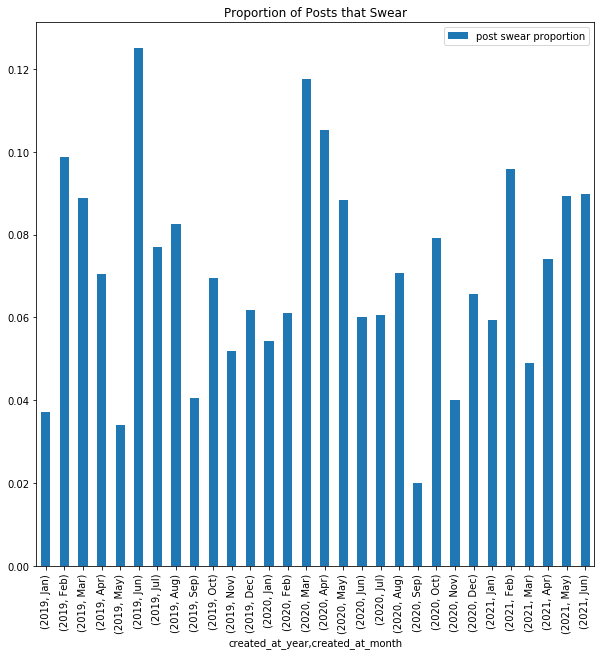

In [157]:
import calendar

# plot the proportion of posts that swear the last two years
swore_year_month = swore.drop(["created_at_day"], axis=1)
swore_year_month = swore_year_month.groupby(["created_at_year", "created_at_month"]).mean()
month_int_to_str = {m: calendar.month_abbr[m] for m in range(1, 13)}
swore_year_month = swore_year_month.rename(month_int_to_str, axis='index')
swore_year_month = swore_year_month.rename(columns={'swore?':'post swear proportion'})
ax = swore_year_month.plot.bar(figsize=(10,10), y="post swear proportion", title="Proportion of Posts that Swear")

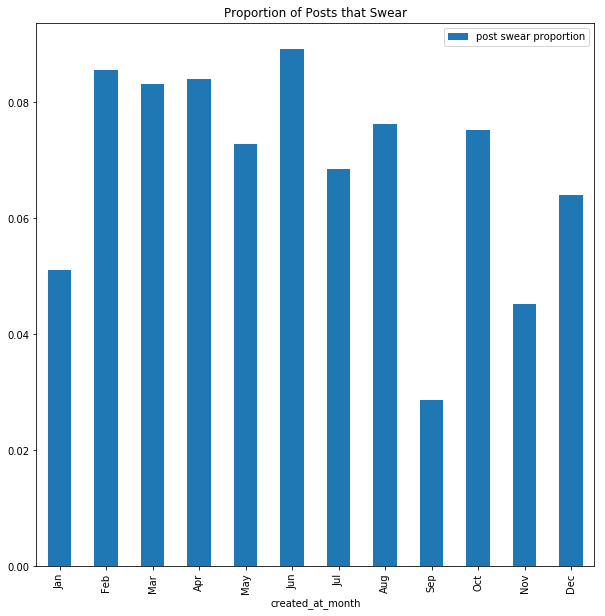

In [158]:
# plot the proportion of posts that swear each month 
swore_month = swore.drop(["created_at_day", "created_at_year"], axis=1)
swore_month = swore_month.groupby("created_at_month").mean()
month_int_to_str = {m: calendar.month_abbr[m] for m in range(1, 13)}
swore_month = swore_month.rename(month_int_to_str, axis='index')
swore_month = swore_month.rename(columns={'swore?':'post swear proportion'})
ax = swore_month.plot.bar(figsize=(10,10), y="post swear proportion", title="Proportion of Posts that Swear")

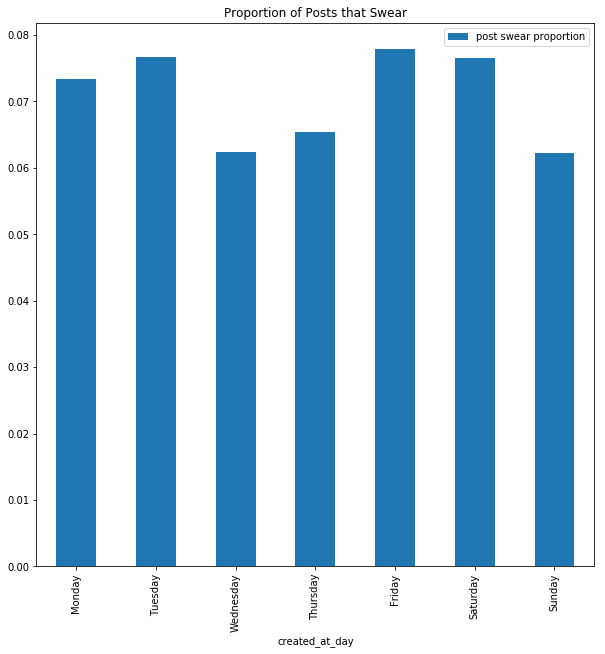

In [162]:
# plot the proportion of posts that swear on each day of the week 
swore_day = swore.drop(["created_at_year", "created_at_month"], axis=1)
swore_day = swore_day.groupby("created_at_day").mean()
day_int_to_str = {d: calendar.day_name[d] for d in range(7)}
swore_day = swore_day.rename(day_int_to_str, axis='index')
swore_day = swore_day.rename(columns={'swore?':'post swear proportion'})
ax = swore_day.plot.bar(figsize=(10,10), y="post swear proportion", title="Proportion of Posts that Swear")

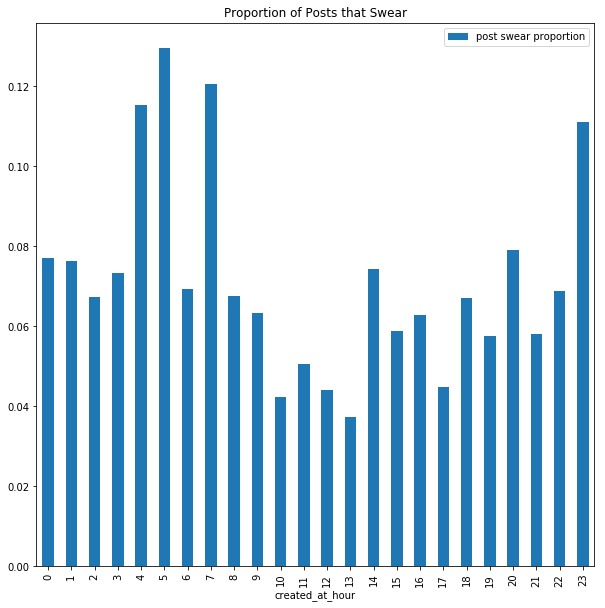